In [ ]:
!pip install seaborn

In [35]:
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.corpus import reuters
from collections import Counter, defaultdict
import random

In [36]:
uploaded = files.upload()

Saving GrammarandProductReviews.csv to GrammarandProductReviews (2).csv


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
data = pd.read_csv(io.BytesIO(uploaded['GrammarandProductReviews.csv']))

In [41]:
data.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2018-02-04T07:28:12Z,"2018-01-15T04:45:00.000Z,2018-01-18T14:30:00.0...",NaN,NaN,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-23T02:53:06Z,2017-09-16T09:45:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-06T04:49:31Z,2017-08-23T10:37:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,67981934427


El archivo CSV contiene 25 columnas, es necesario procesar y limpiar los datos.

# **Limpieza de datos:**

Identificar valores nulos para eliminar esa retroalimentación vacía

In [42]:
data.isnull().sum()

id                          0
brand                       0
categories                  0
dateAdded                   0
dateUpdated                 0
ean                     31979
keys                        0
manufacturer              141
manufacturerNumber        203
name                        0
reviews.date               67
reviews.dateAdded           0
reviews.dateSeen            0
reviews.didPurchase     38886
reviews.doRecommend     10615
reviews.id              38886
reviews.numHelpful      38536
reviews.rating              0
reviews.sourceURLs          0
reviews.text               36
reviews.title             476
reviews.userCity        65634
reviews.userProvince    70595
reviews.username           96
upc                         2
dtype: int64

Eliminar los valores nulos de arriba

In [43]:
data = data.dropna(subset=['reviews.text'])

ELiminar minúsculas y mayúsculas

In [44]:
data['reviews.text'] = data['reviews.text'].apply(lambda line: line.lower())

Eminar caracteres especiales

In [45]:
import string
punc_ext = string.punctuation + '¡¿'
def remove_punctuation(text):
    return text.translate(text.maketrans('', '', punc_ext))

In [46]:
remove_punctuation('¡Excelente! Les gusto!?')

'Excelente Les gusto'

Eliminar los URL

In [47]:
import re
def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

In [48]:
data['reviews.text'] = data['reviews.text'].apply(lambda line: remove_url(line))

Eliminar emoticones

In [ ]:
!pip install emoji

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=8458b7cc24f9881bd799be8c7a5c41d0a61c64b81f4a929a1a0f945109847f9b
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [49]:
import emoji
data['reviews.text'] = data['reviews.text'].apply(lambda line: emoji.demojize(line))

ELiminar STOPWORDS

In [50]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [51]:
stopwords=set(stopwords.words('english'))
trendy_words=['im','rt','jk','btw','lol','yolo','lmao','lmfao','fb','like','get']
for i in trendy_words:
    stopwords.add(i)

# **Análisis exploratorio**

Frecuencias 

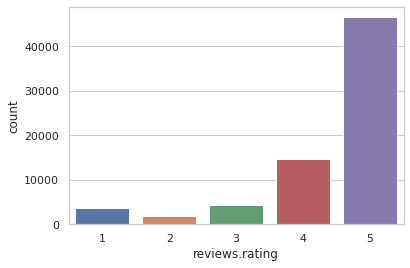

In [52]:
sns.set(style="whitegrid")
sns.countplot(data['reviews.rating'])

### Palabras más utilizadas por rating, en wordclouds

In [55]:
r1 = data.loc[data['reviews.rating']==1, ['reviews.text']]
r2 = data.loc[data['reviews.rating']==2, ['reviews.text']]
r3 = data.loc[data['reviews.rating']==3, ['reviews.text']]
r4 = data.loc[data['reviews.rating']==4, ['reviews.text']]
r5 = data.loc[data['reviews.rating']==5, ['reviews.text']]

Se dividieron por puntuaciones las reviews de los usuarios.

In [58]:
stopwords = set(STOPWORDS)

def frequent_words(dato):
    wordcloud = WordCloud(
        background_color='skyblue',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(dato))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

Rating=1

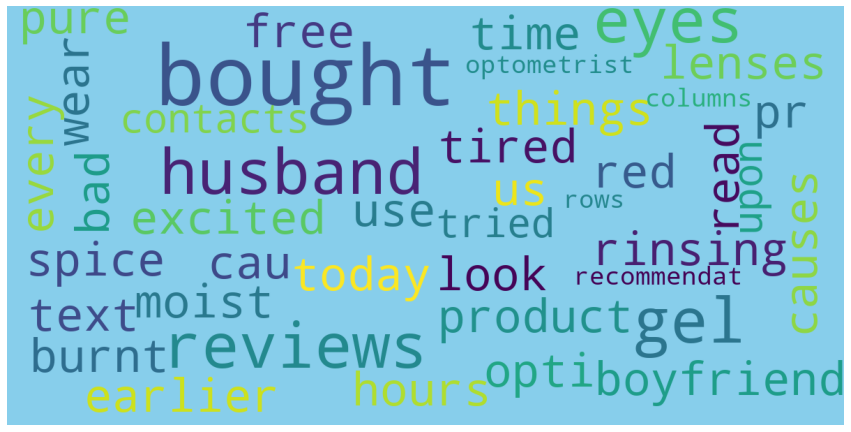

In [59]:
frequent_words(r1)

Rating=2

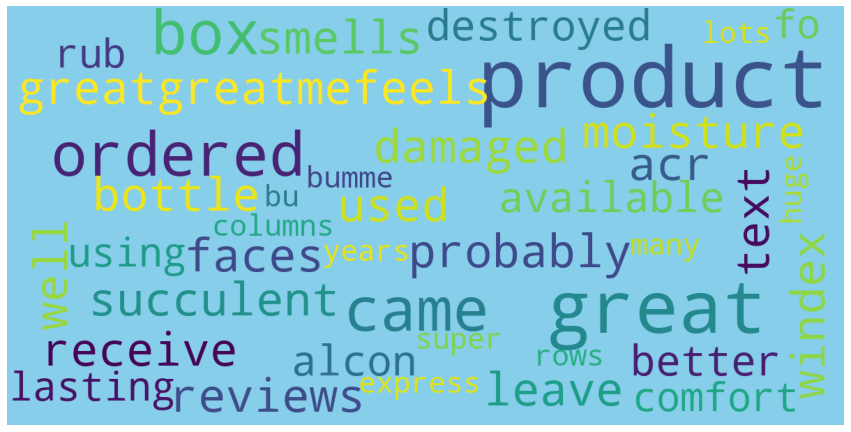

In [60]:
frequent_words(r2)

Rating=3

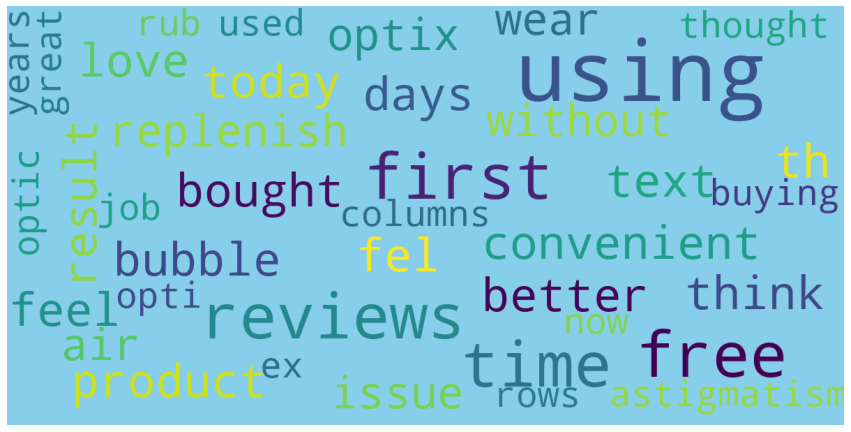

In [61]:
frequent_words(r3)

Rating=4

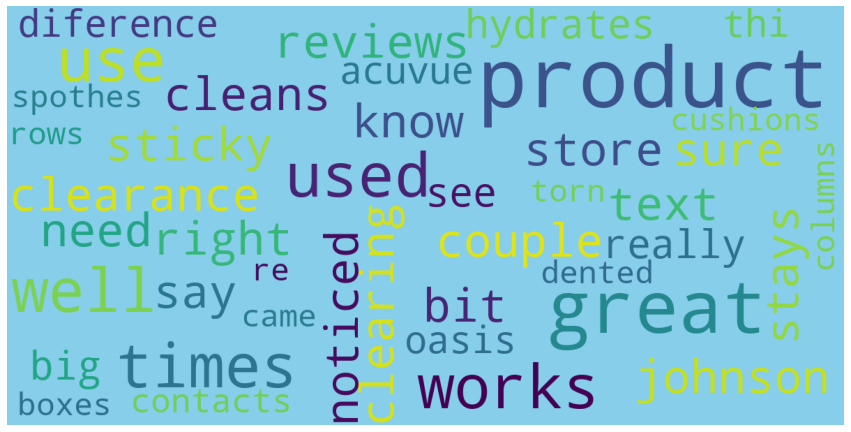

In [62]:
frequent_words(r4)

Rating=5

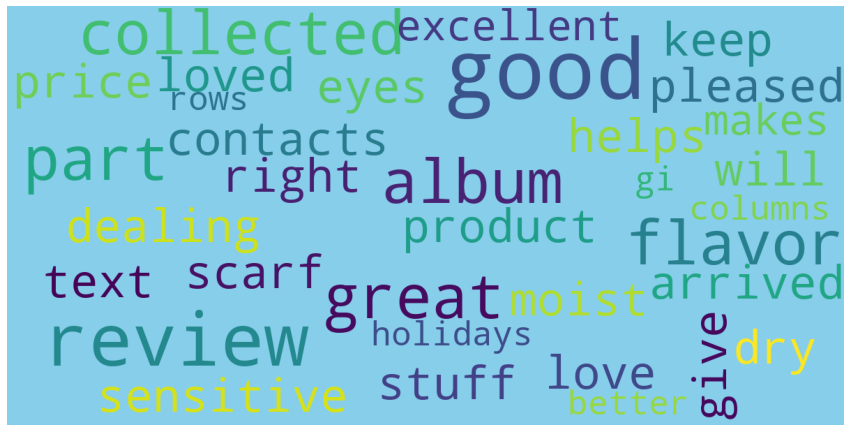

In [63]:
frequent_words(r5)

## Histograma de las palabras que más se repiten

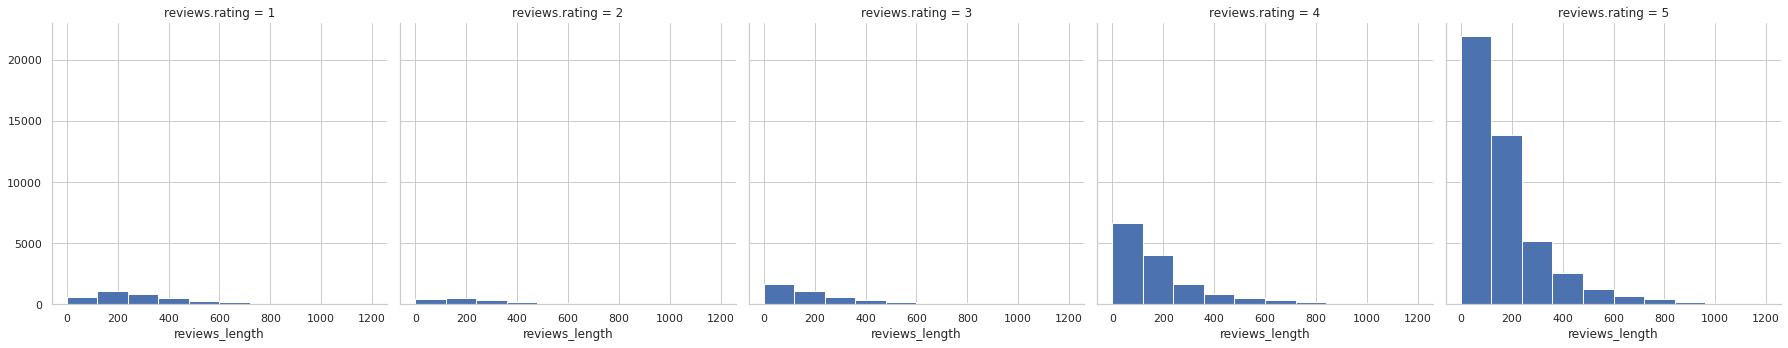

In [64]:
data['reviews_length'] = data['reviews.text'].apply(len)
g = sns.FacetGrid(data,col='reviews.rating',size=5)
g.map(plt.hist,'reviews_length', range=(0, 1200))

Arriba se muestra el número de palabras más frecuentes según su rating, el rating 5 al ser el más votado de igual forma tiene mayor número de repeticiones

# **Determinar palabras positivas y negativas**

Se deben de crear nuevas clasificaciones para agregar las palabras "positivas" y las "negativas"

In [66]:
def clasificarRating(rate):
    if rate < 3:
        return 'Negativa'
    elif rate == 3:
        return 'Neutra'
    else:
        return 'Positiva'

In [67]:
data['ReviewType'] = data['reviews.rating'].apply(lambda rate: clasificarRating(rate))

In [68]:
def clasificarRating2(rate):
    if rate < 3:
        return '0'
    elif rate == 3:
        return '1'
    else:
        return '2'

In [69]:
data['numberRate'] = data['reviews.rating'] < 4

Utilizar funciones de clasificación para obtener las positivas y negativas

In [71]:
positivas = {}
negativas = {}
    
for review, classType in zip(data['reviews.text'], data['ReviewType']):
    text = review.split(' ')
    for word in text:
        if word not in stopwords and word != '':
            if classType == 'Positiva':
                counter = positivas.get(word)
                if counter:
                    positivas[word] = counter + 1
                else:
                    positivas[word] = 1
            elif classType == 'Negativa':
                counter = negativas.get(word)
                if counter:
                    negativas[word] = counter + 1
                else:
                    negativas[word] = 1

Para encontrar las positivas:

In [72]:
import operator
best_positive = sorted(positivas.items(), key=operator.itemgetter(1))
best_positive.reverse()
best_positive

[('part', 16878),
 ('review', 16775),
 ('collected', 16243),
 ('great', 16187),
 ('promotion.', 15621),
 ('love', 15545),
 ('movie', 11660),
 ('use', 11643),
 ('product', 11219),
 ('good', 8591),
 ('really', 7259),
 ('skin', 6788),
 ('one', 6582),
 ('will', 6298),
 ('using', 6055),
 ('hair', 5879),
 ('clean', 5697),
 ('easy', 5008),
 ('it.', 4847),
 ('used', 4447),
 ('clorox', 4012),
 ('movie.', 3761),
 ('wipes', 3709),
 ('much', 3654),
 ('best', 3649),
 ('first', 3453),
 ('recommend', 3434),
 ('well', 3423),
 ('feel', 3404),
 ('smell', 3395),
 ('kids', 3378),
 ('loved', 3363),
 ('even', 3342),
 ('little', 3292),
 ('tide', 3237),
 ('always', 3206),
 ('time', 3127),
 ('family', 3067),
 ('buy', 2892),
 ('product.', 2762),
 ('definitely', 2647),
 ('products', 2641),
 ('makes', 2610),
 ('see', 2607),
 ('make', 2590),
 ('received', 2576),
 ('keep', 2565),
 ('dry', 2454),
 ('better', 2418),
 ('every', 2403),
 ('soft', 2371),
 ('works', 2362),
 ('bought', 2357),
 ('nice', 2355),
 ('now', 2347

Las palabras positivas se asocian a cosas materiales cercanas o útiles como las almohadas o auriculares.

Para las negativas:

In [73]:
best_negative = sorted(negativas.items(), key=operator.itemgetter(1))
best_negative.reverse()
best_negative

[('product', 2055),
 ('new', 1495),
 ('used', 1314),
 ('one', 1285),
 ('use', 1198),
 ('will', 1150),
 ('using', 1043),
 ('hair', 1008),
 ('old', 991),
 ('mop', 903),
 ('bought', 898),
 ('formula', 896),
 ('back', 845),
 ('now', 820),
 ('tide', 815),
 ('it.', 810),
 ('first', 725),
 ('really', 651),
 ('good', 641),
 ('part', 631),
 ('review', 622),
 ('gel', 615),
 ('great', 597),
 ('skin', 591),
 ('spray', 586),
 ('time', 569),
 ('product.', 566),
 ('even', 555),
 ('bottle', 533),
 ('buy', 533),
 ('collected', 526),
 ('promotion.', 525),
 ('tried', 519),
 ('pods', 518),
 ('smell', 518),
 ('love', 489),
 ('years', 483),
 ('please', 480),
 ('much', 462),
 ('scent', 422),
 ('try', 419),
 ('bring', 413),
 ('find', 412),
 ('movie', 407),
 ('original', 402),
 ('disappointed', 400),
 ('never', 399),
 ('clothes', 387),
 ('work', 386),
 ('loved', 379),
 ('2', 376),
 ('got', 365),
 ('made', 363),
 ('still', 355),
 ('thought', 352),
 ('two', 350),
 ('another', 350),
 ('products', 350),
 ('make', 

La mayoría de negativas se asocian con malas experiencias como "pero", "perder", "comosea", "aruinado", "sucio".

In [74]:
def return_next(modelo, texto):
    return diccionario[:6]

# **Algoritmo para la clasificación**

In [75]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

In [76]:
np.random.seed(32)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.utils.np_utils import to_categorical

In [77]:
train_text, test_text, train_y, test_y = train_test_split(data['reviews.text'],data['numberRate'],test_size = 0.3)

In [78]:
MAX_NB_WORDS = 20000

texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index

In [79]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in sequences[0]])

'i purchased this movie for my kids the family really enjoyed this movie good laughs'

Esta review corresponde a palabras positivas con una calificación positiva

In [80]:
MAX_SEQUENCE_LENGTH = 150

x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [81]:
y_train = train_y
y_test = test_y

y_train = to_categorical(np.asarray(y_train))
print('Shape of label tensor:', y_train.shape)


Shape of label tensor: (49705, 2)


In [82]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = 2

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [83]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

## Long Short Term Memory Networks

Se utilizó este modelo porque no es necesario que la red recuerde todas las puntuaciones (ratings), simplemente obtiene un resultado por cada puntuación, de esta forma trabaja más rápido y de igual forma no afecta el resultado.

In [84]:
x = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
predictions = Dense(2, activation='softmax')(x)


model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [88]:
model.fit(x_train, y_train, validation_split=0.1, batch_size=128)

350/350 [==============================] - 248s 710ms/step - loss: 0.2742 - acc: 0.8953 - val_loss: 0.2300 - val_acc: 0.9109


In [89]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:,1]))

test auc: 0.9177883376626709


Como se muestra en el valor "test accuracy" se obtiene una precisión del 92% lo cuál es un valor muy acertado hablando de predicciones.

algunas modificaciones para responder las preguntas

In [93]:
!pip install textblob

In [94]:
from textblob import TextBlob

In [95]:
def get_sentiment(text): 
    analysis = TextBlob(text) 
    # set sentiment 
    if analysis.sentiment.polarity > 0: 
        return 'positivo'
    elif analysis.sentiment.polarity == 0: 
        return 'neutral'
    else: 
        return 'negativo'

In [96]:
clasify_sent = data['reviews.text'].apply(lambda x: get_sentiment(x))

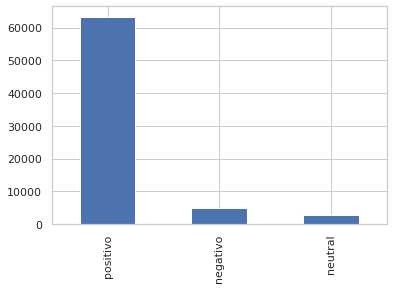

In [97]:
number = clasify_sent.value_counts()
number
number.plot.bar()

In [98]:
data['sentiment'] = clasify_sent
data[['reviews.text', 'sentiment']]

,reviews.text,sentiment
0,i love this album. it's very good. more to the...,positivo
1,good flavor. this review was collected as part...,positivo
2,good flavor.,positivo
3,i read through the reviews on here before look...,negativo
4,my husband bought this gel for us. the gel cau...,neutral
...,...,...
71039,i'm dealing with dry eyes and very sensitive t...,negativo
71040,great stuff! helps keep my contacts moist all ...,positivo
71041,right price,positivo
71042,i was so pleased when this scarf arrived for m...,positivo


Cuáles son los 10 productos de mejor calidad dado su review

In [99]:
most_positive = data[(data['reviews.rating'] == 5) | (data['reviews.didPurchase'] == 'True') | (data['sentiment'] == 'positivo')]
print('LOS DE MEJOR CALIDAD')
print(most_positive['name'].head(10))

LOS DE MEJOR CALIDAD
0      Pink Friday: Roman Reloaded Re-Up (w/dvd)
1     Lundberg Organic Cinnamon Toast Rice Cakes
2     Lundberg Organic Cinnamon Toast Rice Cakes
9               K-Y Love Sensuality Pleasure Gel
11              K-Y Love Sensuality Pleasure Gel
14              K-Y Love Sensuality Pleasure Gel
18              K-Y Love Sensuality Pleasure Gel
20              K-Y Love Sensuality Pleasure Gel
21              K-Y Love Sensuality Pleasure Gel
22              K-Y Love Sensuality Pleasure Gel
Name: name, dtype: object


Cuáles son los 10 productos de menor calidad dado su review

In [100]:
most_negative = data[(data['reviews.rating'] == 1) | (data['reviews.didPurchase'] == 'True') | (data['sentiment'] == 'negativo')]
print('LOS DE PEOR CALIDAD')
print(most_negative['name'].head(10))

LOS DE PEOR CALIDAD
3     K-Y Love Sensuality Pleasure Gel
4     K-Y Love Sensuality Pleasure Gel
5     K-Y Love Sensuality Pleasure Gel
6     K-Y Love Sensuality Pleasure Gel
7     K-Y Love Sensuality Pleasure Gel
8     K-Y Love Sensuality Pleasure Gel
9     K-Y Love Sensuality Pleasure Gel
10    K-Y Love Sensuality Pleasure Gel
11    K-Y Love Sensuality Pleasure Gel
12    K-Y Love Sensuality Pleasure Gel
Name: name, dtype: object


Cuáles son los usuarios que dan la mayor cantidad de reviews a distintos productos

In [101]:
most_comments = data['reviews.username'].value_counts()
print(most_comments.head(10))

An anonymous customer    421
Anonymous                113
Mike                     105
Chris                     88
ByAmazon Customer         58
Dave                      57
John                      49
Rick                      41
James                     32
Robert                    31
Name: reviews.username, dtype: int64


Cuáles son los usuarios que más reviews negativos y positivos dan en promedio

In [104]:
print("Users")
most_positive_comments = data[(data['sentiment'] == 'positivo')]
user_most = most_positive_comments['reviews.username'].value_counts()
print(most_positive_comments['reviews.username'].head(10))

least_positive_comments = data[(data['sentiment'] == 'negativo')]
user_least = least_positive_comments['reviews.username'].value_counts()
print(least_positive_comments['reviews.username'].head(10))

Users
0                  Joshua
1               Dorothy W
2               Dorothy W
9                Moore222
11                 Bre234
14                 Nicole
18                   LL24
20    Just Faith everyday
21                   vero
22                  Jo276
Name: reviews.username, dtype: object
3                   Rebecca
5                  Samantha
6                   Raeanne
7                    Kimmie
8                    cassie
12                  jds1992
13                 Gordy313
15                  Cvperez
17                  sanchez
41    An anonymous customer
Name: reviews.username, dtype: object


Cuáles son los productores que tienen productos de mejor calidad

In [105]:
mostBrand_positive = data[(data['reviews.rating'] == 5) | (data['reviews.didPurchase'] == 'True') | (data['sentiment'] == 'negativo')]
print('LOS DE MEJOR CALIDAD')
print(mostBrand_positive['brand'].head(10))

LOS DE MEJOR CALIDAD
0     Universal Music
1            Lundberg
2            Lundberg
3                 K-Y
5                 K-Y
6                 K-Y
7                 K-Y
8                 K-Y
12                K-Y
13                K-Y
Name: brand, dtype: object


Cuáles son los productores que tienen productos de peor calidad

In [106]:
most_negative_pro = data[(data['reviews.rating'] == 1) | (data['reviews.didPurchase'] == 'True') | (data['sentiment'] == 'negativo')]
print(most_negative_pro['brand'].head(10))

3     K-Y
4     K-Y
5     K-Y
6     K-Y
7     K-Y
8     K-Y
9     K-Y
10    K-Y
11    K-Y
12    K-Y
Name: brand, dtype: object


## ¿Qué le propondría a esta empresa para mejorar sus productos?

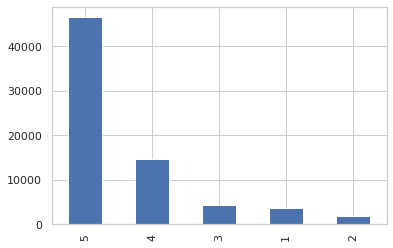

In [107]:
review_rate = data['reviews.rating'].value_counts()
review_rate
review_rate.plot.bar()

Según el análisis previo, los productos con peores ratings son lo que se asocian con palabras negativas. Deberían de tomar en cuenta las palabras con las que describen esos productos para mejorarlos y brindar una mejor experiencia de usuario. En las wordclouds del rating 1 y 2, se podrían recalcar "without" que indica que faltaba algo y "destroyed" o "damaged" que indica que el producto no llegó a su destinto en un estado óptimo.